In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import cntk
from cntk import *
from cntk.layers import *
%matplotlib inline

In [2]:
class Target_Agent:
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.epsilon = 1
        
        # Create the model and set up trainer
        self.input_var = input(input_dim, np.float32)
        self.output_var = input(output_dim, np.float32)
        self.online_model = self.create_network()

        learning_rate = 0.0025
        loss = reduce_mean(square(self.online_model - self.output_var), axis=0)
        lr_schedule = learning_rate_schedule(learning_rate, UnitType.sample)
        learner = sgd(self.online_model.parameters, lr_schedule)
        self.trainer = Trainer(self.online_model, loss, learner)
        
        # Create target network and initialize with same weights
        self.target_model = self.create_network()
        self.update_target()
        
    def create_network(self):
        scale = 1e-4
        return Sequential([
            Dense(16, activation=relu, name='dense1', init=uniform(scale) ,init_bias=uniform(scale)),
            Dense(16, activation=relu, name='dense2', init=uniform(scale) ,init_bias=uniform(scale)),
            Dense(self.output_dim, name='z', init=uniform(scale), init_bias=uniform(scale))
        ])(self.input_var)
    
    def update_target(self):
        """
        Updates the target network using the online network weights
        """
        self.target_model = self.online_model.clone(CloneMethod.clone)
        
    def update_epsilon(self, episode):
        """
        Updates epsilon using exponential decay with the decay rate chosen such
        that epsilon is 0.05 by episode 10000
        """
        self.epsilon = max(math.exp(-2.996e-4 * episode), 0.05)
        
    def predict(self, s, target=False):
        """
        Feeds a state through the model (our network) and obtains the values of each action
        """
        if target:
            return self.target_model.eval(s)[0]
        else:
            return self.online_model.eval(s)[0]
        
    def act(self, s):
        """
        Selects an action using the epoch-greedy approach
        """
        if random.random() > self.epsilon:
            # Exploit (greedy)            
            return np.argmax(self.predict(s))
        else:
            # Explore (random action)
            return random.randint(0, self.output_dim - 1)
        
    def train(self, x, y):
        """
        Performs a single gradient descent step
        """
        self.trainer.train_minibatch({self.input_var: x, self.output_var: y})
        
    def evaluate(self, env, n):
        """
        Computes the average performance of the agent over n episodes
        """
        episode = 0
        rewards = 0
        
        while episode < n:
            s = env.reset()
            done = False
            while not done:
                a = np.argmax(self.predict(s.astype(np.float32)))
                s, r, done, info = env.step(a)
                rewards += r
            episode += 1
        
        return rewards / float(n)

In [3]:
def train(env, agent, episodes, gamma, update_freq, use_target=True):
    """
    param env: The gym environment to train with
    param episodes: The number of episodes to train for
    param gamma: The discount factor
    """    
    episode = 0
    rewards = 0
    episode_rewards = []
    s = env.reset().astype(np.float32)
    
    while episode < episodes:
        # Select action using policy derived from Q (e-greedy) 
        a = agent.act(s)

        # Take action and observe next state and reward
        s_, r, done, info = env.step(a)
        s_ = s_.astype(np.float32)

        y = agent.predict(s)
        if use_target:
            q_next = agent.predict(s_, target=True)
        else:
            q_next = agent.predict(s_)
        
        if done:
            y[a] = r
        else:
            y[a] = r + gamma * np.amax(q_next)

        agent.train(s, y)

        s = s_
        rewards += r

        # Episode over, reset environment
        if done:                
            episode += 1
            episode_rewards.append(rewards)

            if episode % 200 == 0:
                print('Episode {}, reward = {}'.format(episode, rewards))
                
            if episode % update_freq == 0 and use_target:
                agent.update_target()

            s = env.reset().astype(np.float32)
            rewards = 0
    return episode_rewards

In [4]:
gamma = 0.99
episodes = 15000
update_freq = 1000

In [5]:
env = gym.make('CartPole-v0')

input_dim = env.observation_space.shape
output_dim = env.action_space.n

agent = Target_Agent(input_dim, output_dim)
agent2 = Target_Agent(input_dim, output_dim)

[2017-04-20 14:32:56,998] Making new env: CartPole-v0


In [6]:
rewards = train(env, agent, episodes, gamma, update_freq, use_target=False)


Episode 200, reward = 13.0
Episode 400, reward = 14.0
Episode 600, reward = 12.0
Episode 800, reward = 25.0
Episode 1000, reward = 43.0
Episode 1200, reward = 14.0
Episode 1400, reward = 19.0
Episode 1600, reward = 19.0
Episode 1800, reward = 12.0
Episode 2000, reward = 11.0
Episode 2200, reward = 21.0
Episode 2400, reward = 10.0
Episode 2600, reward = 28.0
Episode 2800, reward = 11.0
Episode 3000, reward = 17.0
Episode 3200, reward = 12.0
Episode 3400, reward = 25.0
Episode 3600, reward = 10.0
Episode 3800, reward = 11.0
Episode 4000, reward = 13.0
Episode 4200, reward = 25.0
Episode 4400, reward = 18.0
Episode 4600, reward = 26.0
Episode 4800, reward = 33.0
Episode 5000, reward = 17.0
Episode 5200, reward = 34.0
Episode 5400, reward = 10.0
Episode 5600, reward = 27.0
Episode 5800, reward = 26.0
Episode 6000, reward = 25.0
Episode 6200, reward = 26.0
Episode 6400, reward = 12.0
Episode 6600, reward = 18.0
Episode 6800, reward = 26.0
Episode 7000, reward = 33.0
Episode 7200, reward = 3

In [7]:
rewards_target = train(env, agent2, episodes, gamma, update_freq)

Episode 200, reward = 48.0
Episode 400, reward = 26.0
Episode 600, reward = 13.0
Episode 800, reward = 20.0
Episode 1000, reward = 14.0
Episode 1200, reward = 20.0
Episode 1400, reward = 47.0
Episode 1600, reward = 28.0
Episode 1800, reward = 27.0
Episode 2000, reward = 27.0
Episode 2200, reward = 16.0
Episode 2400, reward = 16.0
Episode 2600, reward = 30.0
Episode 2800, reward = 11.0
Episode 3000, reward = 22.0
Episode 3200, reward = 24.0
Episode 3400, reward = 32.0
Episode 3600, reward = 14.0
Episode 3800, reward = 14.0
Episode 4000, reward = 14.0
Episode 4200, reward = 18.0
Episode 4400, reward = 22.0
Episode 4600, reward = 12.0
Episode 4800, reward = 20.0
Episode 5000, reward = 17.0
Episode 5200, reward = 27.0
Episode 5400, reward = 25.0
Episode 5600, reward = 38.0
Episode 5800, reward = 15.0
Episode 6000, reward = 10.0
Episode 6200, reward = 21.0
Episode 6400, reward = 15.0
Episode 6600, reward = 17.0
Episode 6800, reward = 10.0
Episode 7000, reward = 17.0
Episode 7200, reward = 1

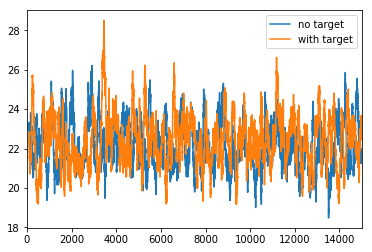

In [8]:
pd.Series(rewards).rolling(window=100).mean().plot(label='no target')
pd.Series(rewards_target).rolling(window=100).mean().plot(label='with target')
plt.legend()
plt.show()

In [9]:
ave_with_target = agent.evaluate(env, 100)
print('Average (with target network) = {}'.format(ave_with_target))


Average (with target network) = 9.42


In [10]:
for i in range(100):
    s = env.reset()
    done = False
    while not done:
        env.render()
        a = agent2.act(s.astype(np.float32))
        s, r, done, info = env.step(a)

In [11]:
env.close()